In [1]:
from dataclasses import dataclass

from pathlib import Path

import numpy as np

import random

import albumentations as aug

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import (
    Callback,
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard,
)
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt


2022-02-19 09:26:24.099530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clement/Workspace/oc_p8/env/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-19 09:26:24.099553: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
size_pixels = 160

img_size = (size_pixels, size_pixels)
num_classes = 8
batch_size = 32
original_size = (2048, 1024)

# Image augmentation : None for no augmentation
augment = aug.Compose(
    [
        # aug.OneOf(  # Weather augmentations
        #     [
        #         aug.RandomRain(),
        #         aug.RandomFog(),
        #         aug.RandomShadow(),
        #         aug.RandomSnow(),
        #         aug.RandomSunFlare(),
        #     ]
        # ),
        aug.OneOf(  # Color augmentations
            [
                aug.RandomBrightnessContrast(),
                aug.RandomGamma(),
                aug.RandomToneCurve(),
            ]
        ),
        aug.OneOf(  # Camera augmentations
            [
                aug.MotionBlur(),
                aug.GaussNoise(),
            ]
        ),
        aug.OneOf(  # Geometric augmentations
            [
                aug.HorizontalFlip(),
                aug.RandomCrop(
                    width=int(img_size[0] / random.uniform(1.0, 3.0)),
                    height=int(img_size[1] / random.uniform(1.0, 3.0)),
                ),
                aug.SafeRotate(
                    limit=15,
                ),
            ]
        ),
        aug.Resize(
            width=img_size[0],
            height=img_size[1],
        ),
    ]
)

model_name = (
    f"unet_xception_{size_pixels}{'_augmented' if augment is not None else ''}"
)
model_path = Path("./../results/", model_name)


In [3]:
@dataclass(frozen=True)
class CityscapesCategory:
    """Cityscapes categories.

    Attributes:
        id: The category id
        name: The category name
        color: The category color
    """

    id: int
    name: str
    color_rgb: tuple[int, int, int]
    label_ids: list[int]


# Cityscape categories
CITYSCAPES_CATEGORIES = [
    CityscapesCategory(
        0,
        "void",
        (0, 0, 0),  # black
        list(range(0, 7)),
    ),
    CityscapesCategory(
        1,
        "flat",
        (128, 64, 128),  # purple
        list(range(7, 11)),
    ),
    CityscapesCategory(
        2,
        "construction",
        (70, 70, 70),  # dark gray
        list(range(11, 17)),
    ),
    CityscapesCategory(
        3,
        "object",
        (153, 153, 153),  # light gray
        list(range(17, 21)),
    ),
    CityscapesCategory(
        4,
        "nature",
        (107, 142, 35),  # olive
        list(range(21, 23)),
    ),
    CityscapesCategory(
        5,
        "sky",
        (70, 130, 180),  # blue
        list(range(23, 24)),
    ),
    CityscapesCategory(
        6,
        "human",
        (220, 20, 60),  # crimson
        list(range(24, 26)),
    ),
    CityscapesCategory(
        7,
        "vehicle",
        (0, 0, 142),  # navy
        [-1] + list(range(26, 34)),
    ),
]


def cityscapes_label_ids_to_category_ids(img: np.array) -> np.array:
    """Convert cityscapes label ids to category ids.

    Args:
        img: Cityscapes label ids image

    Returns:
        Category ids image
    """
    if not len(img.shape) == 2:
        raise ValueError("Image must be of shape (H, W).")

    category_ids = np.zeros(img.shape, dtype=np.uint8)

    for category in CITYSCAPES_CATEGORIES:
        for label_id in category.label_ids:
            category_ids[img == label_id] = category.id

    return category_ids


def cityscapes_category_ids_to_category_colors(img: np.array) -> np.array:
    """Convert cityscapes category ids to colors.

    Args:
        img: Cityscapes category ids image

    Returns:
        Category colors image
    """
    if not len(img.shape) == 2:
        raise ValueError("Image must be of shape (H, W).")

    category_colors = np.zeros(img.shape + (3,), dtype=np.uint8)

    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            category_colors[row, col] = CITYSCAPES_CATEGORIES[
                img[row, col]
            ].color_rgb

    return category_colors


In [4]:
raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")


# Train dataset
train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_labelIds.png")
)
train_label_colors_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_color.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)

# Test dataset
test_input_img_paths = sorted(
    Path(leftImg8bit_path, "test").glob("**/*.png")
)
test_label_ids_img_paths = sorted(
    Path(gtFine_path, "test").glob("**/*_labelIds.png")
)
test_label_colors_img_paths = sorted(
    Path(gtFine_path, "test").glob("**/*_color.png")
)


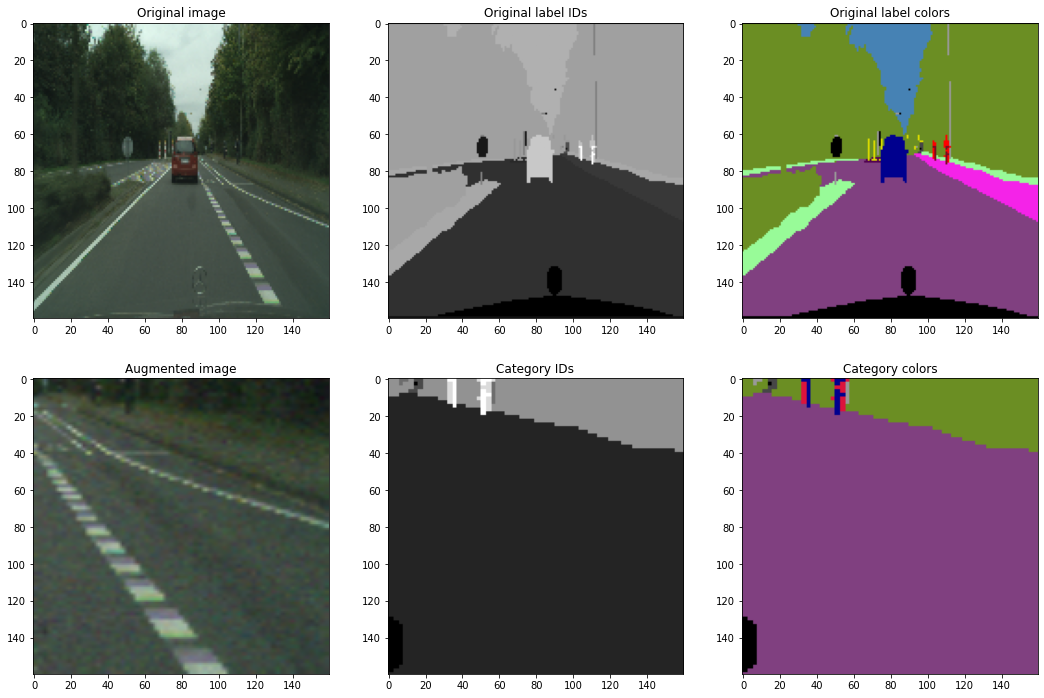

In [5]:
rand_idx = np.random.randint(0, len(train_input_img_paths))


fig, ax = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(18, 12),
)

ax[0, 0].title.set_text("Original image")
input_img = load_img(train_input_img_paths[rand_idx], target_size=img_size)
ax[0, 0].imshow(input_img)

ax[0, 1].title.set_text("Original label IDs")
label_ids = load_img(
    train_label_ids_img_paths[rand_idx],
    target_size=img_size,
    color_mode="grayscale",
)
ax[0, 1].imshow(label_ids, cmap="gray")

ax[0, 2].title.set_text("Original label colors")
input_colors = load_img(
    train_label_colors_img_paths[rand_idx], target_size=img_size
)
ax[0, 2].imshow(input_colors)

if augment is not None:
    augmented = augment(
        image=np.array(input_img),
        mask=np.expand_dims(
            cityscapes_label_ids_to_category_ids(np.array(label_ids)),
            2,
        ),
    )

    ax[1, 0].title.set_text("Augmented image")
    ax[1, 0].imshow(augmented["image"])

    category_ids = augmented["mask"]
else:
    category_ids = cityscapes_label_ids_to_category_ids(np.array(label_ids))

ax[1, 1].title.set_text("Category IDs")
ax[1, 1].imshow(category_ids, cmap="gray")

ax[1, 2].title.set_text("Category colors")
category_colors = cityscapes_category_ids_to_category_colors(
    np.squeeze(category_ids)
)
ax[1, 2].imshow(category_colors)

plt.show()


In [6]:
class CityscapesGenerator(Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(
        self,
        batch_size,
        img_size,
        input_img_paths,
        label_ids_img_paths,
        augment=None,
    ):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.label_ids_img_paths = label_ids_img_paths
        self.augment = augment

    def __len__(self):
        return len(self.label_ids_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size

        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype=np.uint8)
        for j, path in enumerate(batch_input_img_paths):
            x[j] = np.array(load_img(path, target_size=self.img_size))

        batch_label_ids_img_paths = self.label_ids_img_paths[
            i : i + self.batch_size
        ]
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype=np.uint8)
        for j, path in enumerate(batch_label_ids_img_paths):
            y[j] = np.expand_dims(
                cityscapes_label_ids_to_category_ids(
                    np.array(
                        load_img(
                            path,
                            target_size=self.img_size,
                            color_mode="grayscale",
                        )
                    )
                ),
                2,
            )

        if self.augment is not None:
            for j in range(self.batch_size):
                augmented = self.augment(
                    image=x[j],
                    mask=y[j],
                )
                x[j] = augmented["image"]
                y[j] = augmented["mask"]

        return x, y


class CityscapesViewerCallback(Callback):
    def on_epoch_end(self, epoch=None, logs=None):
        rand_idx = np.random.randint(0, len(val_input_img_paths))

        fig, ax = plt.subplots(
            nrows=1,
            ncols=3,
            figsize=(18, 6),
        )

        ax[0].title.set_text("Original image")
        val_img = load_img(
            val_input_img_paths[rand_idx], target_size=img_size
        )
        ax[0].imshow(val_img)

        ax[1].title.set_text("Original label colors")
        val_colors = load_img(
            val_label_colors_img_paths[rand_idx], target_size=img_size
        )
        ax[1].imshow(val_colors)

        ax[2].title.set_text("Predicted category colors")
        pred_colors = cityscapes_category_ids_to_category_colors(
            np.squeeze(
                np.argmax(
                    self.model.predict(np.expand_dims(val_img, 0)), axis=-1
                )
            )
        )
        ax[2].imshow(pred_colors)

        plt.show()


class UpdatedMeanIoU(MeanIoU):
    """Custom metric to report the mean IoU over the entire batch.

    See : https://github.com/tensorflow/tensorflow/issues/32875#issuecomment-707316950
    """

    def __init__(
        self, y_true=None, y_pred=None, num_classes=None, name=None, dtype=None
    ):
        super(UpdatedMeanIoU, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)


def jaccard_loss(y_true, y_pred, smooth=100.0):
    """
    See : https://towardsdatascience.com/image-segmentation-choosing-the-correct-metric-aa21fd5751af
    """

    y_true = tf.squeeze(tf.one_hot(y_true, num_classes))

    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1) - intersection
    jac = (intersection + smooth) / (union + smooth)

    return (1 - jac) * smooth


In [7]:
def unet_xception_model(img_size, num_classes, model_name="unet_xception"):
    """Creates a U-Net model with Xception as the encoder.

    See : https://keras.io/examples/vision/oxford_pets_image_segmentation/

    Args:
        img_size: tuple of (height, width)
        num_classes: number of classes to predict

    Returns:
        keras.models.Model
    """
    inputs = Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(
        num_classes, 3, activation="softmax", padding="same"
    )(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    return model


# Free up RAM in case the model definition cells were run multiple times
clear_session()

# Build model
if Path(model_path, "model").exists():
    model = load_model(
        Path(model_path, "model"),
        custom_objects={
            "UpdatedMeanIoU": UpdatedMeanIoU,
            "jaccard_loss": jaccard_loss,
        },
    )
else:
    model = unet_xception_model(img_size, num_classes, model_name=model_name)

model.summary()


2022-02-19 09:26:29.137091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clement/Workspace/oc_p8/env/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-19 09:26:29.137119: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-19 09:26:29.137141: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gros-bernard): /proc/driver/nvidia/version does not exist
2022-02-19 09:26:29.137626: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "unet_xception_160_augmented"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                        

Loading model from ../results/unet_xception_160_augmented/checkpoint.h5
Epoch 1/100
92/92 [==============================] - ETA: 0s - loss: 0.2788 - MeanIoU: 0.5403
Epoch 1: val_loss improved from inf to 0.34108, saving model to ../results/unet_xception_160_augmented/checkpoint.h5


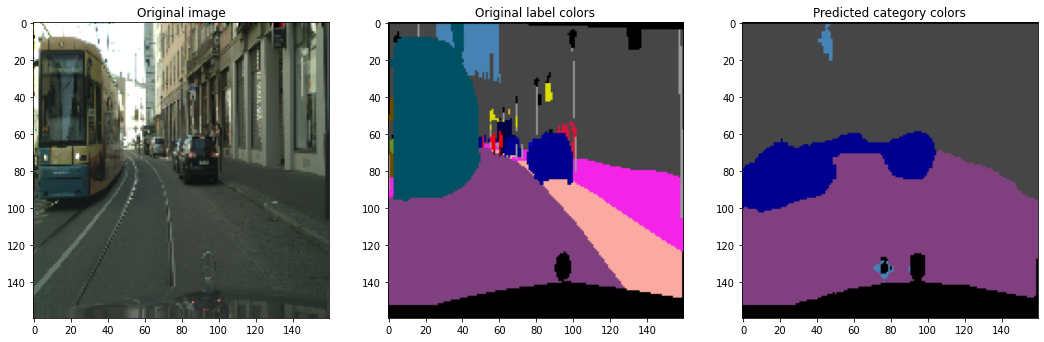

92/92 [==============================] - 591s 6s/step - loss: 0.2788 - MeanIoU: 0.5403 - val_loss: 0.3411 - val_MeanIoU: 0.4985 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 0.2618 - MeanIoU: 0.5543
Epoch 2: val_loss improved from 0.34108 to 0.32437, saving model to ../results/unet_xception_160_augmented/checkpoint.h5


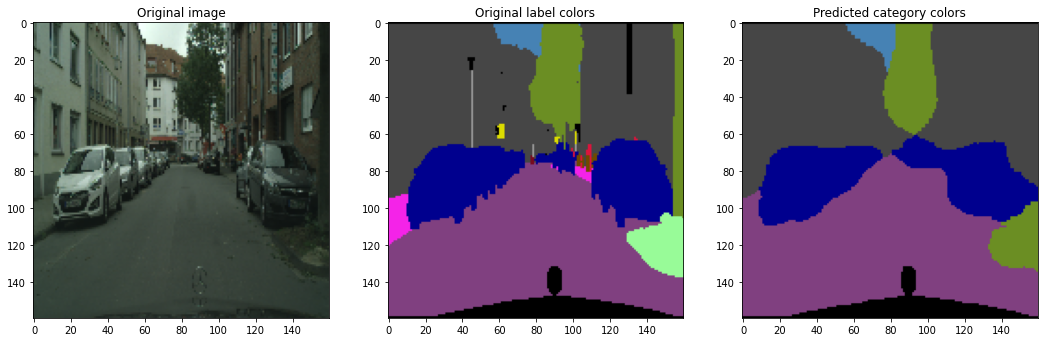

92/92 [==============================] - 563s 6s/step - loss: 0.2618 - MeanIoU: 0.5543 - val_loss: 0.3244 - val_MeanIoU: 0.5127 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - ETA: 0s - loss: 0.2537 - MeanIoU: 0.5611
Epoch 3: val_loss did not improve from 0.32437

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


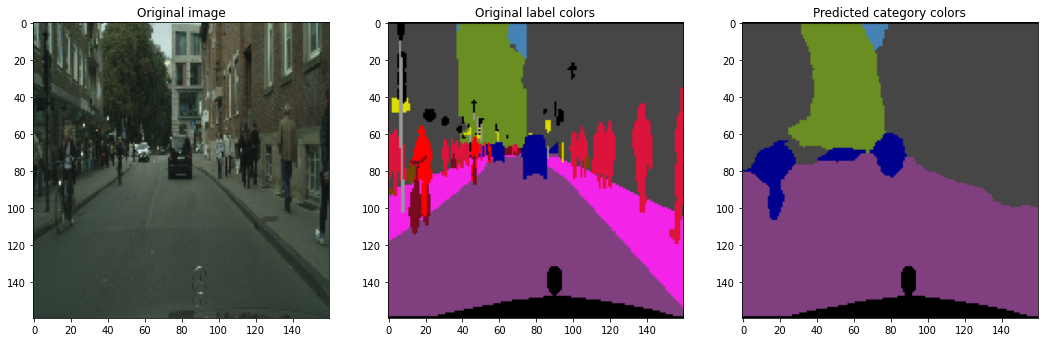

92/92 [==============================] - 561s 6s/step - loss: 0.2537 - MeanIoU: 0.5611 - val_loss: 0.3251 - val_MeanIoU: 0.5040 - lr: 0.0010
Epoch 4/100
92/92 [==============================] - ETA: 0s - loss: 0.2387 - MeanIoU: 0.5734
Epoch 4: val_loss improved from 0.32437 to 0.31002, saving model to ../results/unet_xception_160_augmented/checkpoint.h5


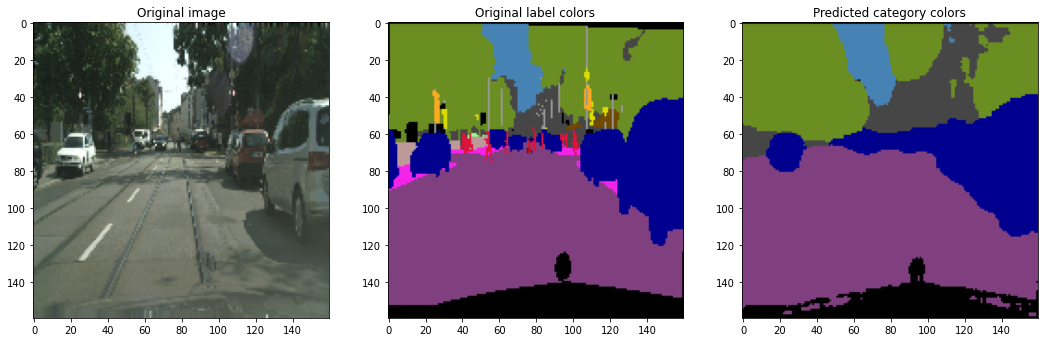

92/92 [==============================] - 544s 6s/step - loss: 0.2387 - MeanIoU: 0.5734 - val_loss: 0.3100 - val_MeanIoU: 0.5256 - lr: 5.0000e-04
Epoch 5/100
92/92 [==============================] - ETA: 0s - loss: 0.2314 - MeanIoU: 0.5790
Epoch 5: val_loss did not improve from 0.31002

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


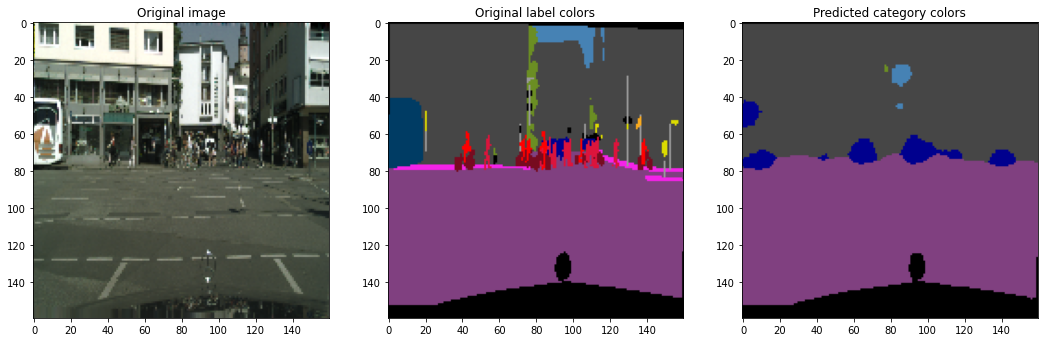

92/92 [==============================] - 555s 6s/step - loss: 0.2314 - MeanIoU: 0.5790 - val_loss: 0.3132 - val_MeanIoU: 0.5235 - lr: 5.0000e-04
Epoch 6/100
92/92 [==============================] - ETA: 0s - loss: 0.2235 - MeanIoU: 0.5851
Epoch 6: val_loss improved from 0.31002 to 0.30729, saving model to ../results/unet_xception_160_augmented/checkpoint.h5


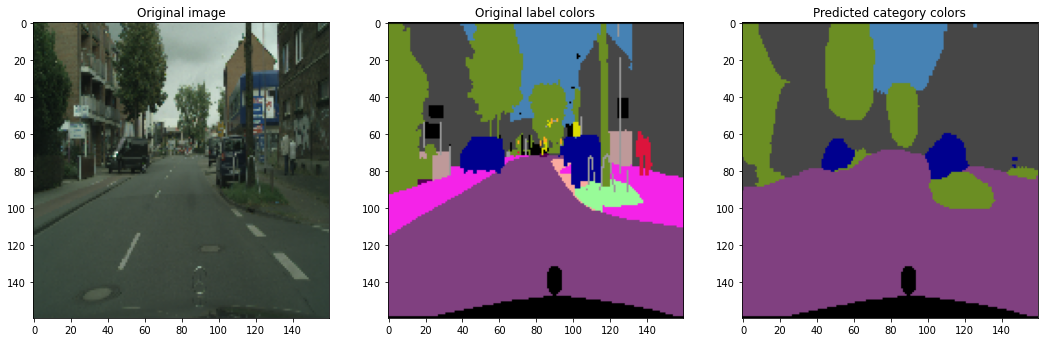

92/92 [==============================] - 562s 6s/step - loss: 0.2235 - MeanIoU: 0.5851 - val_loss: 0.3073 - val_MeanIoU: 0.5281 - lr: 2.5000e-04
Epoch 7/100
92/92 [==============================] - ETA: 0s - loss: 0.2199 - MeanIoU: 0.5877
Epoch 7: val_loss improved from 0.30729 to 0.30406, saving model to ../results/unet_xception_160_augmented/checkpoint.h5


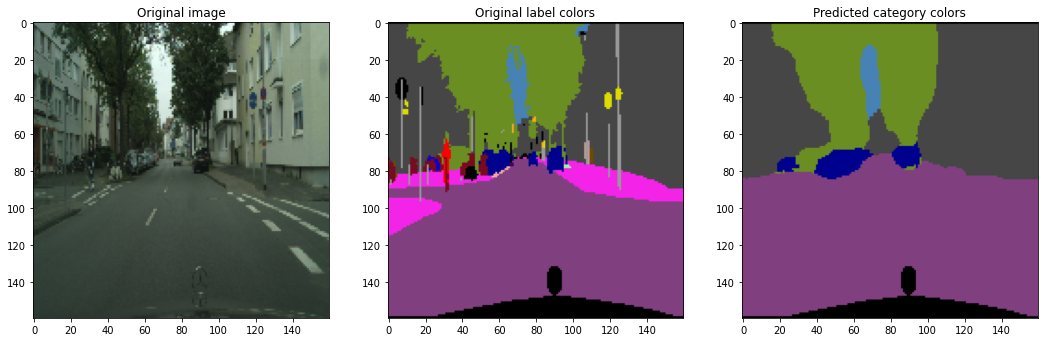

92/92 [==============================] - 578s 6s/step - loss: 0.2199 - MeanIoU: 0.5877 - val_loss: 0.3041 - val_MeanIoU: 0.5294 - lr: 2.5000e-04
Epoch 8/100
92/92 [==============================] - ETA: 0s - loss: 0.2166 - MeanIoU: 0.5902
Epoch 8: val_loss did not improve from 0.30406

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


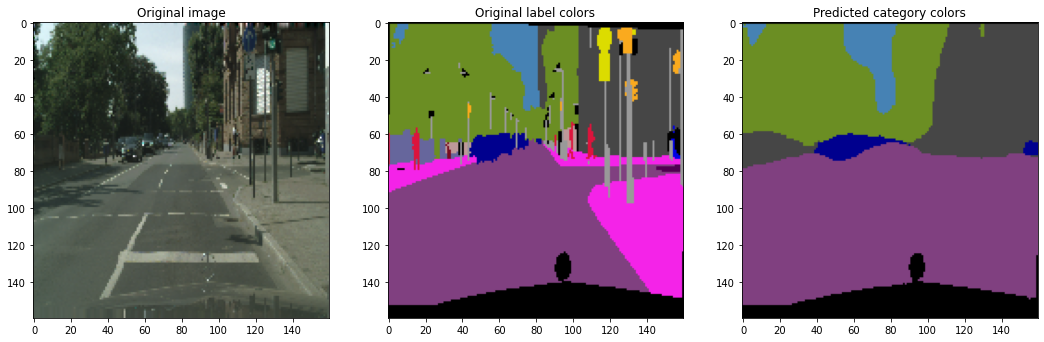

92/92 [==============================] - 575s 6s/step - loss: 0.2166 - MeanIoU: 0.5902 - val_loss: 0.3073 - val_MeanIoU: 0.5265 - lr: 2.5000e-04
Epoch 9/100
92/92 [==============================] - ETA: 0s - loss: 0.2126 - MeanIoU: 0.5932
Epoch 9: val_loss improved from 0.30406 to 0.30390, saving model to ../results/unet_xception_160_augmented/checkpoint.h5

Epoch 9: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


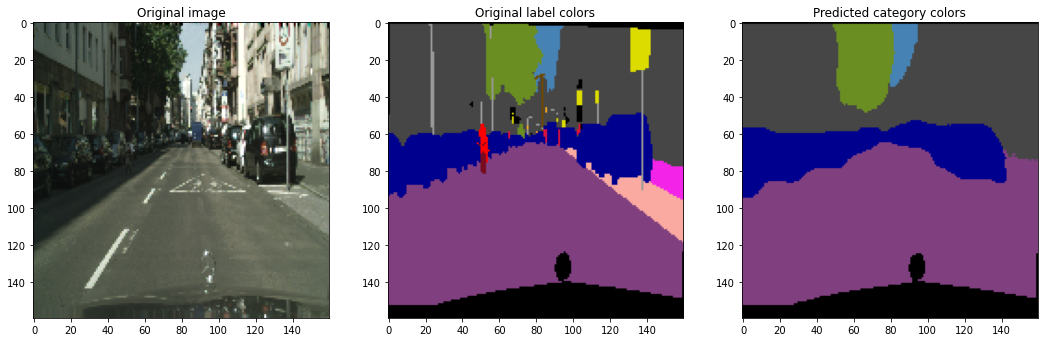

92/92 [==============================] - 561s 6s/step - loss: 0.2126 - MeanIoU: 0.5932 - val_loss: 0.3039 - val_MeanIoU: 0.5274 - lr: 1.2500e-04
Epoch 10/100
92/92 [==============================] - ETA: 0s - loss: 0.2101 - MeanIoU: 0.5952
Epoch 10: val_loss improved from 0.30390 to 0.30217, saving model to ../results/unet_xception_160_augmented/checkpoint.h5


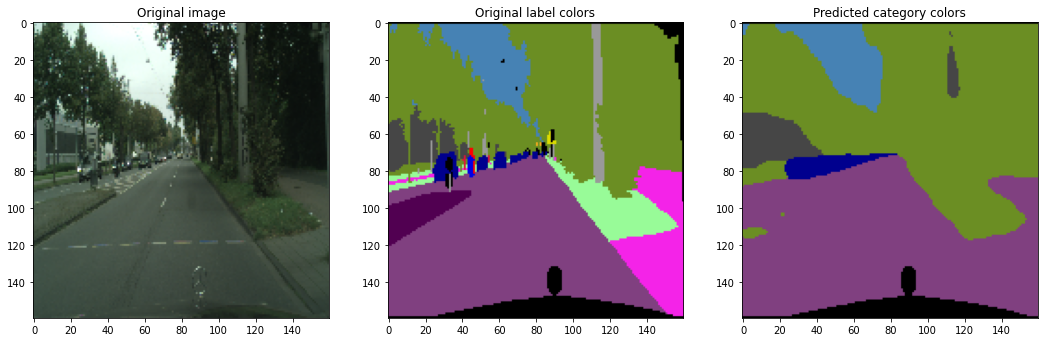

92/92 [==============================] - 534s 6s/step - loss: 0.2101 - MeanIoU: 0.5952 - val_loss: 0.3022 - val_MeanIoU: 0.5295 - lr: 6.2500e-05
Epoch 11/100
92/92 [==============================] - ETA: 0s - loss: 0.2089 - MeanIoU: 0.5961
Epoch 11: val_loss did not improve from 0.30217

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


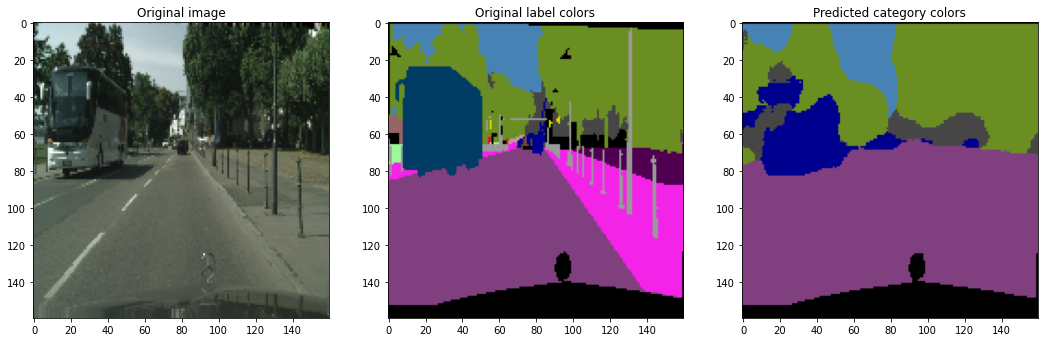

92/92 [==============================] - 547s 6s/step - loss: 0.2089 - MeanIoU: 0.5961 - val_loss: 0.3032 - val_MeanIoU: 0.5279 - lr: 6.2500e-05
Epoch 12/100
92/92 [==============================] - ETA: 0s - loss: 0.2077 - MeanIoU: 0.5970
Epoch 12: val_loss did not improve from 0.30217

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


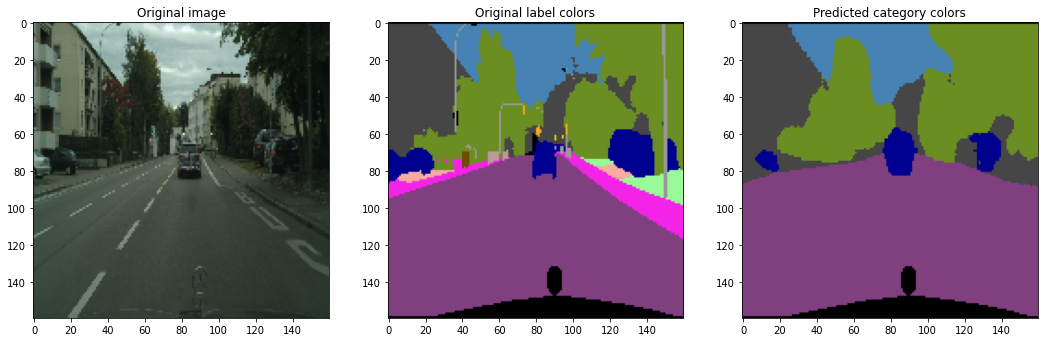

92/92 [==============================] - 533s 6s/step - loss: 0.2077 - MeanIoU: 0.5970 - val_loss: 0.3028 - val_MeanIoU: 0.5283 - lr: 3.1250e-05
Epoch 13/100
92/92 [==============================] - ETA: 0s - loss: 0.2070 - MeanIoU: 0.5976
Epoch 13: val_loss did not improve from 0.30217

Epoch 13: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Restoring model weights from the end of the best epoch: 10.


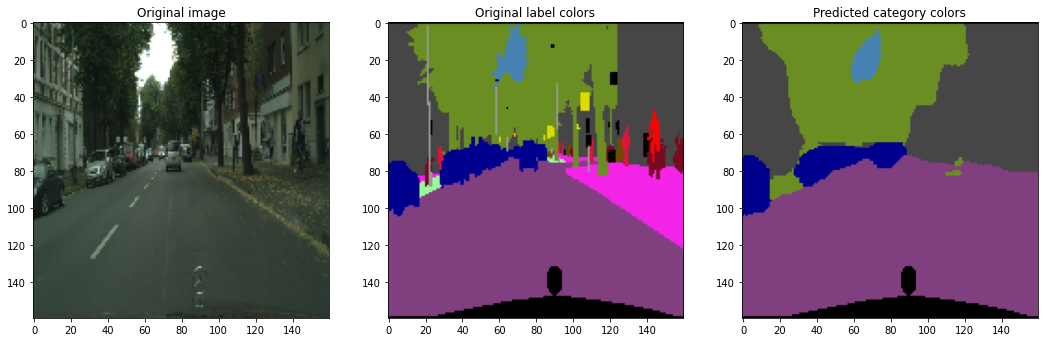

92/92 [==============================] - 552s 6s/step - loss: 0.2070 - MeanIoU: 0.5976 - val_loss: 0.3032 - val_MeanIoU: 0.5278 - lr: 1.5625e-05
Epoch 13: early stopping


2022-02-19 11:29:15.983024: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../results/unet_xception_160_augmented/model/assets


In [8]:
# Configure the model for training.
model.compile(
    optimizer="adam",
    loss=jaccard_loss, # "sparse_categorical_crossentropy",
    metrics=[
        UpdatedMeanIoU(name="MeanIoU", num_classes=num_classes), # https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html
    ],
)

model_checkpoint_path = Path(model_path, "checkpoint.h5")
if model_checkpoint_path.exists():
    print("Loading model from {}".format(model_checkpoint_path))
    model.load_weights(str(model_checkpoint_path))

# Train the model, doing validation at the end of each epoch.
model.fit(
    CityscapesGenerator(
        batch_size, img_size, train_input_img_paths, train_label_ids_img_paths
    ),
    validation_data=CityscapesGenerator(
        batch_size, img_size, val_input_img_paths, val_label_ids_img_paths
    ),
    epochs=100,
    callbacks=[
        ModelCheckpoint(
            model_checkpoint_path,
            save_best_only=True,
            verbose=1,
        ),
        ReduceLROnPlateau(
            patience=1,
            factor=0.5,
            min_delta=1e-3,
            min_lr=1e-9,
            verbose=1,
        ),
        EarlyStopping(
            patience=3,
            restore_best_weights=True,
            min_delta=1e-5,
            verbose=1,
        ),
        TensorBoard(log_dir=Path(model_path, "logs")),
        CityscapesViewerCallback(),
    ],
    # workers=2,
    # use_multiprocessing=True,
)

model.save(Path(model_path, "model"))
